In [6]:
import jax.numpy as jnp
from jax import random, vmap, grad, jacfwd, jit, value_and_grad
from jax.lax import fori_loop
import matplotlib.pyplot as plt
from jax.config import config; config.update("jax_enable_x64", True)
import optax

from tqdm.auto import tqdm

In [7]:
M = 20 # maximum Fourier coefficients
T = 1.0 # period
key = random.PRNGKey(0)

In [8]:
dt = 0.001

def radius(x):
    return jnp.sqrt((x*x).sum())

def q_t(t, coeffs):
    x = jnp.dot(jnp.cos(2.0*jnp.pi*(2*jnp.arange(M))/T * t), coeffs[:, 0])+ jnp.dot(jnp.sin(2.0*jnp.pi*(2*jnp.arange(M)+1)/T * t), coeffs[:, 1])
    y = jnp.dot(jnp.cos(2.0*jnp.pi*(2*jnp.arange(M))/T * t), coeffs[:, 3])+ jnp.dot(jnp.sin(2.0*jnp.pi*(2*jnp.arange(M)+1)/T * t), coeffs[:, 4])
    return jnp.array([x, y])

qdot_t = jacfwd(q_t, argnums=(0))

def lagrangian(state, velocity, mu):
    a1 = jnp.array([-mu, 0.0])
    a2 = jnp.array([1.0-mu, 0.0])
    kinetic = 0.5 * (velocity * velocity).sum()
    coriolis= velocity[1] * state[2]-velocity[2] * state[1]
    potential = (1.0-mu)/radius(state-a1) + mu/radius(state-a2)+0.5 * (state * state).sum()
    return kinetic + coriolis+potential

def action(coeffs, mu):
    ts = jnp.arange(0, T/4, dt)
    states = vmap(lambda t: q_t(t, coeffs))(ts)
    velocities = vmap(lambda t: qdot_t(t, coeffs))(ts)
    lags = vmap(lagrangian, in_axes=(0, 0, None))(states, velocities, mu)
    return lags.mean() * dt

grad_action = grad(action, argnums=0)

def fit(optimizer, init_coeffs, steps, mu):
    opt_state = optimizer.init(init_coeffs)

    @jit
    def updata_fn(i, val):
        params, opt_state, losses = val
        loss, grad = value_and_grad(action, argnums=0)(params, mu)
        updates, opt_state = optimizer.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        losses = losses.at[i].set(loss)
        return [params, opt_state, losses]

    losses = jnp.zeros(steps)
    n_critical = len(init_coeffs)
    critical_vals = jnp.zeros((steps, n_critical))
    init_val = [init_coeffs, opt_state, losses]

    params, _, losses = fori_loop(0, steps, updata_fn, init_val)
    return params, losses

In [9]:
init_coeffs = random.uniform(key, shape=(M, 2))/M
steps = 10**4
adam = optax.adam(learning_rate=10**-3)

mus = jnp.arange(0.1, 0.5, 0.05)
res = []

for mu in tqdm(mus):
    res.append(fit(adam, init_coeffs, steps, mu))

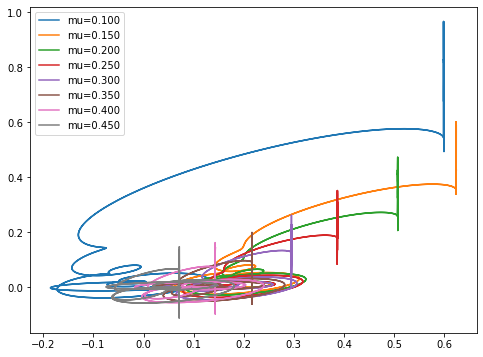

In [10]:
plt.figure(figsize=[8,6])
ts = jnp.arange(0, T, 0.1*dt)
for i in range(len(mus)):
    coeffs = res[i][0]
    orbits = vmap(q_t, in_axes=(0, None))(ts, coeffs)
    plt.plot(orbits[:, 0], orbits[:, 1], label=f"mu={mus[i]:.3f}")
plt.legend()